# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

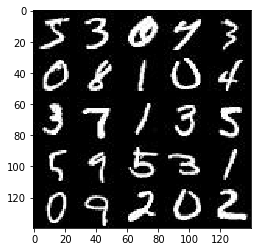

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

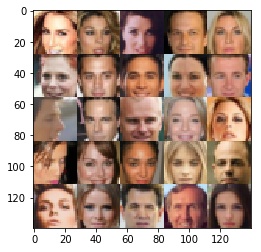

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        #Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        #Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        #Layer 4
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """      
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        if is_train is True:
            drop = 0.5
        else:
            drop = 1.0
            
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='SAME')

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode,print_every=10, 
          show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build network
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                x = x*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4002... Generator Loss: 3.3719
Epoch 1/2... Discriminator Loss: 2.1440... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 6.7488
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 7.0953
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 2.3297... Generator Loss: 0.3568
Epoch 1/2... Discriminator Loss: 2.1241... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 1.9401... Generator Loss: 0.3859
Epoch 1/2... Discriminator Loss: 1.9635... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.9484... Generator Loss: 0.3787


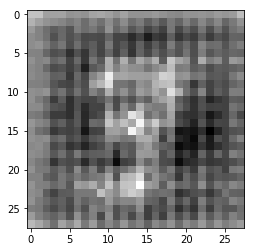

Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.7638... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.6593... Generator Loss: 0.4394
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 1.8979... Generator Loss: 0.3810
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.7916... Generator Loss: 0.4136
Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.6357


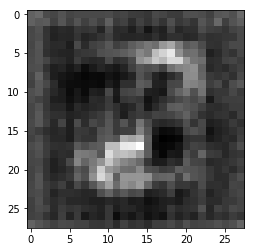

Epoch 1/2... Discriminator Loss: 1.9648... Generator Loss: 2.5119
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 1.7370
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.6121... Generator Loss: 2.0581
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.6600... Generator Loss: 0.4467
Epoch 1/2... Discriminator Loss: 1.9358... Generator Loss: 0.4773
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 2.0581... Generator Loss: 0.3908


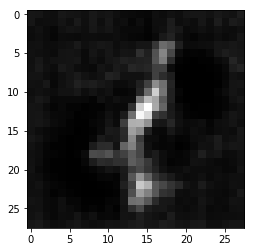

Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 2.3359... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 1.6587... Generator Loss: 0.4649
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.1109
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.5199


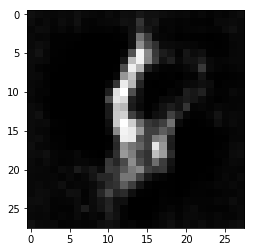

Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.8261... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 1.6957... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.8675... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.9388... Generator Loss: 0.4386
Epoch 1/2... Discriminator Loss: 1.9317... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.6474


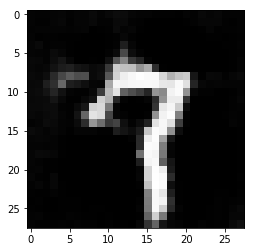

Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.7423... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 2.0038... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.6375... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 1.2781
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 1.1435


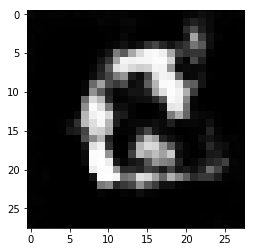

Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 1.9926... Generator Loss: 0.3937
Epoch 1/2... Discriminator Loss: 1.9244... Generator Loss: 0.3947
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.0877
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 2.0901... Generator Loss: 0.3696


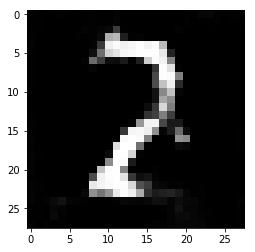

Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.0451
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.4099
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 1.3459


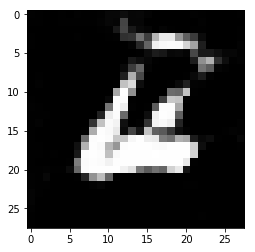

Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 1.7821... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.3880


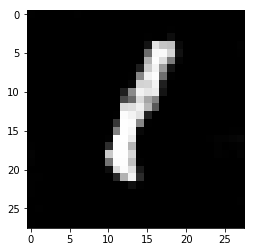

Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 2.0649
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.0574
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.0530
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 1.3759
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.5778


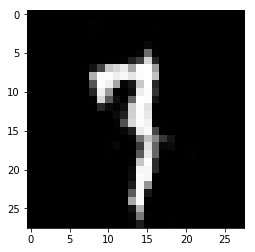

Epoch 1/2... Discriminator Loss: 2.0763... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.6297... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.7194
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 1.8730
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 2.0244... Generator Loss: 0.3917
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.7043


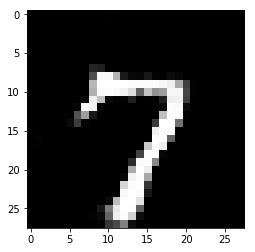

Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 0.9726
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.8685... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.3372
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.2038
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.8898


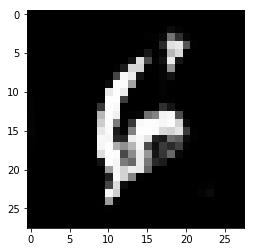

Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 2.1414... Generator Loss: 0.4049
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8113


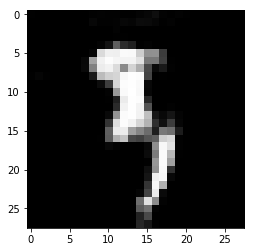

Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.3927
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.1311
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.0172
Epoch 2/2... Discriminator Loss: 1.8430... Generator Loss: 0.4411
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.9633... Generator Loss: 0.4240
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.1399


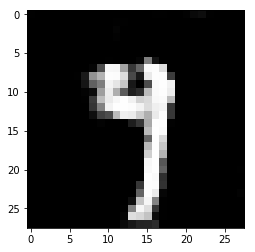

Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.4742
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.7061... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 1.3311


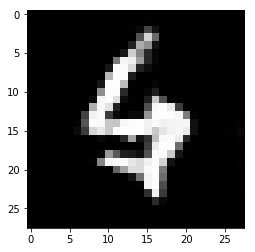

Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.6171
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.0940
Epoch 2/2... Discriminator Loss: 2.0318... Generator Loss: 3.0500
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 1.6030
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.8374... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 1.5512... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 1.2355


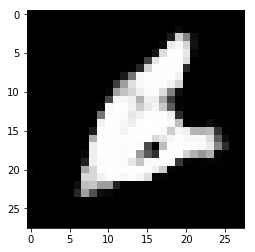

Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 2.0279
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 2.6265... Generator Loss: 3.8438
Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.3962


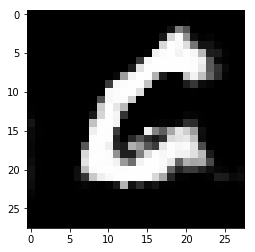

Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.5411
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.9231... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.2168
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 1.7298


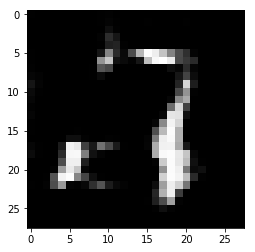

Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.4267
Epoch 2/2... Discriminator Loss: 7.9741... Generator Loss: 8.3558
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.9103
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.6019
Epoch 2/2... Discriminator Loss: 0.9514... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.0564


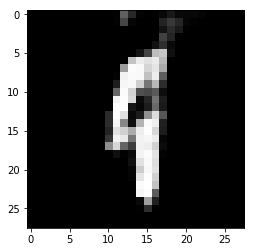

Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.8062
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 3.7535... Generator Loss: 4.5709
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.8672
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.9429


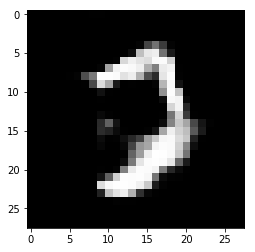

Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 0.6684... Generator Loss: 1.9618
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 2.0436
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 0.9835
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.7845
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.1865
Epoch 2/2... Discriminator Loss: 3.6683... Generator Loss: 4.8630
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.8460
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6390


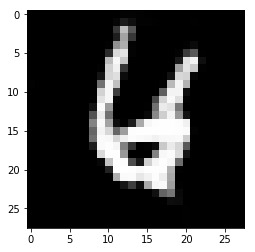

Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.4339
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.0247


In [12]:
batch_size = 56
z_dim = 256
learning_rate = 0.00031
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8334... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 2.8607... Generator Loss: 14.7044
Epoch 1/1... Discriminator Loss: 2.7738... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 5.0954... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 2.9196... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 2.0926... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 2.5503... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 2.5033... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.8687


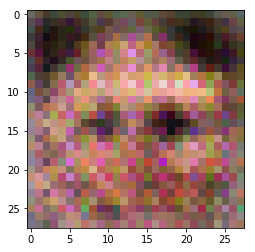

Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 2.1658... Generator Loss: 2.8311
Epoch 1/1... Discriminator Loss: 2.6566... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 3.3494... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 4.4814... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.4684


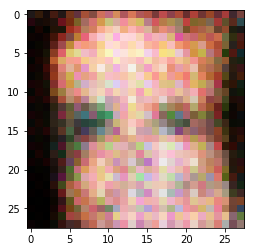

Epoch 1/1... Discriminator Loss: 2.7544... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 4.2836
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 3.4458
Epoch 1/1... Discriminator Loss: 3.4877... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.1974
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 2.4679
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 4.5499
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 0.6198


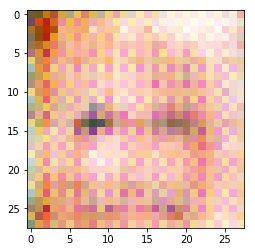

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 5.4366
Epoch 1/1... Discriminator Loss: 2.4749... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 3.0776
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 2.0889... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 3.2007
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5092


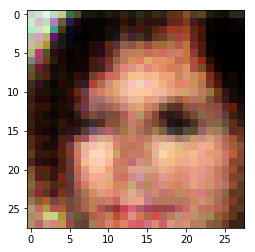

Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.0953
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.7460... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 2.8419... Generator Loss: 0.3480
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 2.5798... Generator Loss: 0.3588


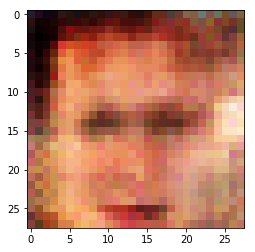

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 3.0010
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 2.2917
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 2.1768... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 5.4467
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.6068
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.9629
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7007


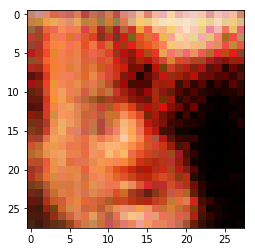

Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.3784
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 2.0943
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.3949
Epoch 1/1... Discriminator Loss: 3.3961... Generator Loss: 3.8669
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 2.3857... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 1.9223


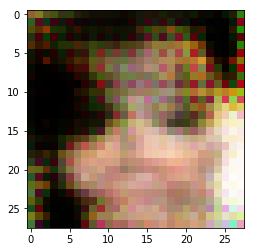

Epoch 1/1... Discriminator Loss: 1.7906... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.9456... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 2.9567
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 4.1469
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 3.5012
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.1977
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 2.1184
Epoch 1/1... Discriminator Loss: 1.9133... Generator Loss: 0.4545


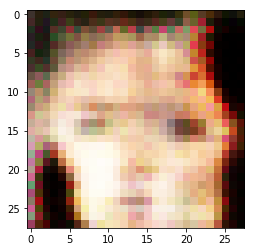

Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.7721
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.7677
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.2626
Epoch 1/1... Discriminator Loss: 2.0237... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 2.7873... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 3.4685... Generator Loss: 0.3570


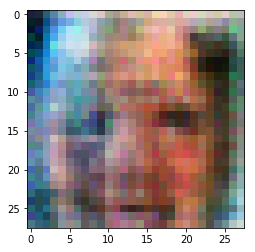

Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 1.9893
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.1313
Epoch 1/1... Discriminator Loss: 2.1646... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.9654... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 2.1242... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.0669


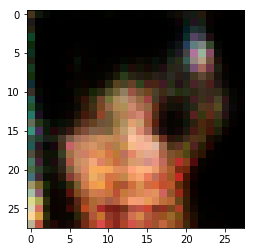

Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 3.2434
Epoch 1/1... Discriminator Loss: 2.1224... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 2.1946... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.6733
Epoch 1/1... Discriminator Loss: 2.1077... Generator Loss: 2.1237
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 2.0035
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.0303


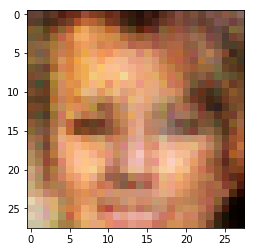

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 2.2125... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 2.2551
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.9519


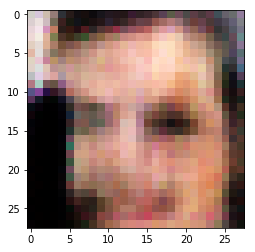

Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.8202
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.7231... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.9336... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.5992


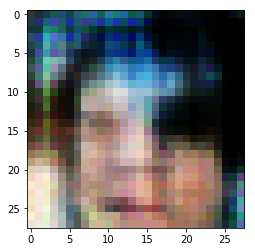

Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.8787... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5344


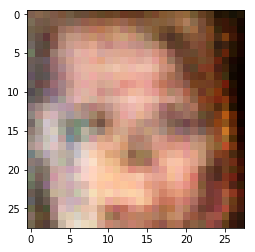

Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.7242... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 2.5666... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 2.0349... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 2.1556... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.4873


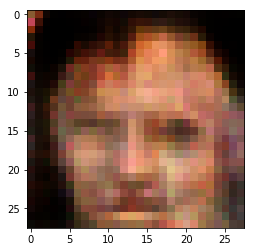

Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 2.3330
Epoch 1/1... Discriminator Loss: 2.2993... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 2.4551... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 2.0371... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.4228
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 2.1321... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 2.1104... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 1.9008... Generator Loss: 0.4194


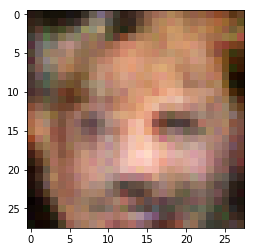

Epoch 1/1... Discriminator Loss: 1.8790... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.2976
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 2.5430... Generator Loss: 0.3337
Epoch 1/1... Discriminator Loss: 2.9789... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.8199


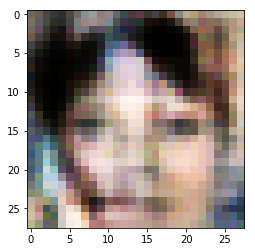

Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.9861... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 2.7845... Generator Loss: 0.3413
Epoch 1/1... Discriminator Loss: 1.9128... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 2.0758... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.4750


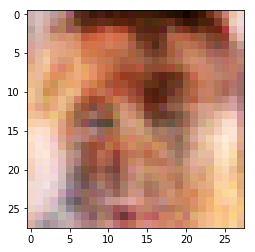

Epoch 1/1... Discriminator Loss: 2.0049... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 3.0126... Generator Loss: 0.3470
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.9007... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 2.1416... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 2.2592... Generator Loss: 0.3615
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 2.5934... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 2.7779... Generator Loss: 0.3552


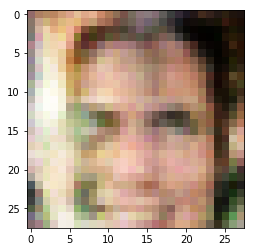

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 2.3706... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 2.3928... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 2.0534... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 2.1656... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 2.0765... Generator Loss: 0.3962


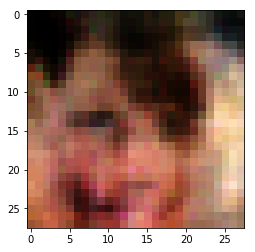

Epoch 1/1... Discriminator Loss: 3.2080... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 2.2501... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 2.4849... Generator Loss: 0.3470
Epoch 1/1... Discriminator Loss: 3.2233... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.9458... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 2.0543... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 2.4363... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6156


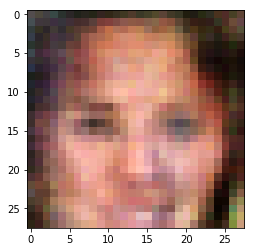

Epoch 1/1... Discriminator Loss: 2.5275... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 2.4621... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 2.4405... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.9969... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 2.6150... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 2.2792... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5876


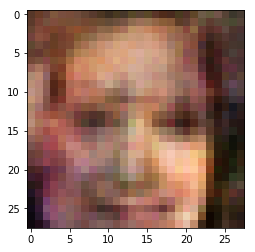

Epoch 1/1... Discriminator Loss: 2.1281... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 2.1294... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 2.6255... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 3.2581... Generator Loss: 0.3466
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.8525... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 2.7768... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 1.8399... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 2.4852... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.8713... Generator Loss: 0.4752


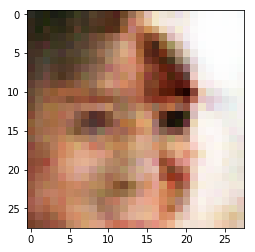

Epoch 1/1... Discriminator Loss: 2.1673... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 2.2714... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 2.5887... Generator Loss: 0.3396
Epoch 1/1... Discriminator Loss: 3.7736... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 2.5169... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.9934... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 3.1622... Generator Loss: 0.3441


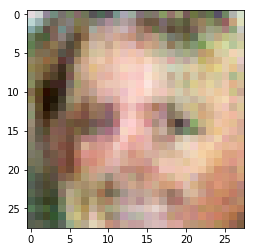

Epoch 1/1... Discriminator Loss: 1.7894... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 3.3208... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 2.2632... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 2.5831... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 3.1672... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 2.4262... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 2.9359... Generator Loss: 0.3420


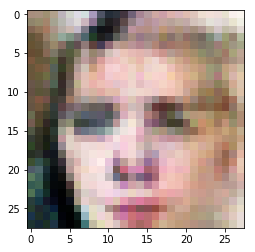

Epoch 1/1... Discriminator Loss: 2.8394... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 2.3740... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.7834... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 2.0082... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 2.5706... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 2.6690... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 1.4292


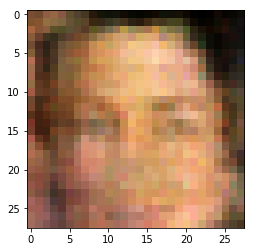

Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 2.1441... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.8224... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 2.3786... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 2.3725... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.7140... Generator Loss: 0.4604


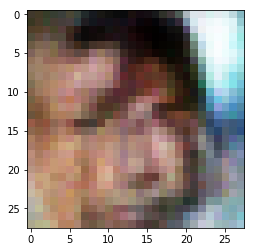

Epoch 1/1... Discriminator Loss: 2.3405... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 2.4243... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 3.3062... Generator Loss: 0.3520
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.9384... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 3.6963... Generator Loss: 0.3852


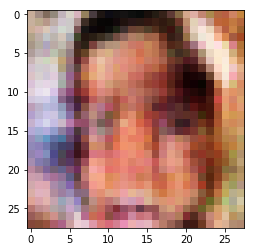

Epoch 1/1... Discriminator Loss: 2.3599... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 2.7196... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 2.6049... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 3.4270... Generator Loss: 0.3642
Epoch 1/1... Discriminator Loss: 2.0597... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.8848... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 2.8333... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 3.1266... Generator Loss: 0.3536


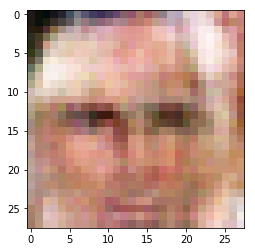

Epoch 1/1... Discriminator Loss: 2.6867... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 1.7085... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 2.0710... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.8880... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.7897... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 3.0789... Generator Loss: 0.3430
Epoch 1/1... Discriminator Loss: 2.1296... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 2.2627... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 2.0402... Generator Loss: 0.4897


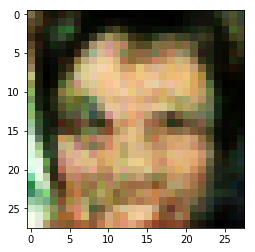

Epoch 1/1... Discriminator Loss: 2.1993... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 2.6932... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 2.2675... Generator Loss: 0.3990
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 2.3284... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 2.3322... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 3.1084... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 1.2432


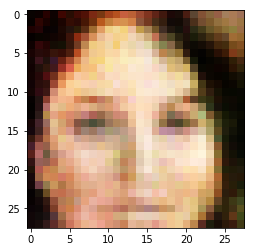

Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 2.0318... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 2.1437... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 2.3564... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5944


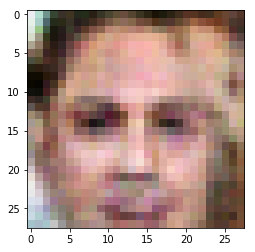

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 2.1828... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.7714... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.8065... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 2.0544... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 2.1957... Generator Loss: 0.8303


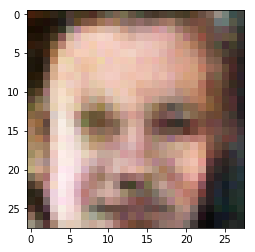

Epoch 1/1... Discriminator Loss: 2.4970... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 1.8969... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 3.0949... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.6766... Generator Loss: 2.2486
Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 2.3445... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9785


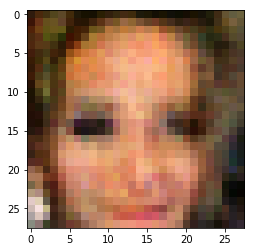

Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 2.5910
Epoch 1/1... Discriminator Loss: 2.0816... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 2.4891... Generator Loss: 0.3542
Epoch 1/1... Discriminator Loss: 2.2152... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 2.9040... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 2.1718... Generator Loss: 0.3817


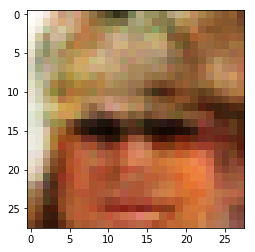

Epoch 1/1... Discriminator Loss: 3.5458... Generator Loss: 0.3733
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 2.9976... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 2.7659... Generator Loss: 0.3724
Epoch 1/1... Discriminator Loss: 1.9754... Generator Loss: 0.4241
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.8580
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.7208


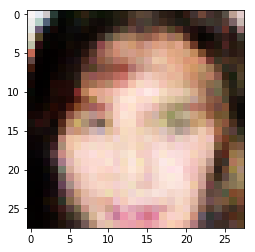

Epoch 1/1... Discriminator Loss: 2.4121... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.7773
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 2.7920
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 3.0731
Epoch 1/1... Discriminator Loss: 1.9630... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.9164... Generator Loss: 0.4235


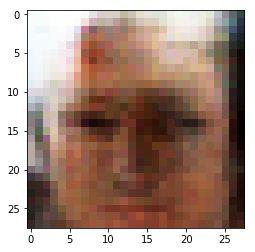

Epoch 1/1... Discriminator Loss: 2.3834... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.7351... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 2.6265... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.9707
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9876


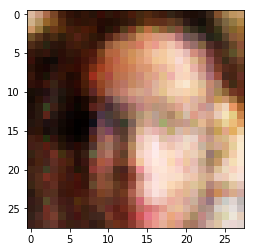

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.9926
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 3.0957
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.4450
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 2.8936... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5706


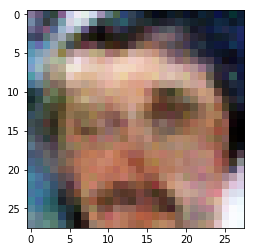

Epoch 1/1... Discriminator Loss: 2.8459... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 2.1035
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.7732... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.9089


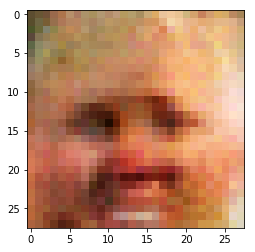

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 3.0157... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 2.6018
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 2.6342
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.7552


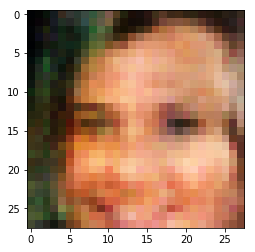

Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 2.7133
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.7214
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.7763
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 2.3497
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.2981


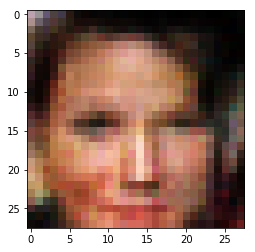

Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.8036
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 4.4292
Epoch 1/1... Discriminator Loss: 2.0046... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 2.8141... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8316


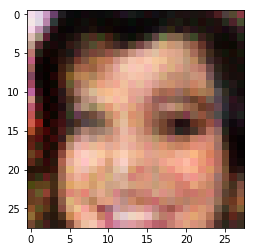

Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 2.4487
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 3.7363
Epoch 1/1... Discriminator Loss: 2.8231... Generator Loss: 0.3545
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.7759... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 2.4779


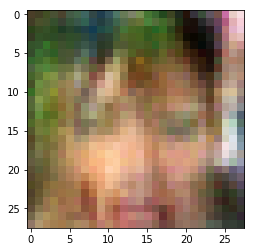

Epoch 1/1... Discriminator Loss: 2.5890... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 2.7516... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 3.3836
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.7710
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.7726... Generator Loss: 1.6020


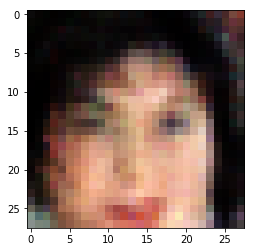

Epoch 1/1... Discriminator Loss: 2.4413... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 2.1402... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 2.6458
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.2917
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 3.4380


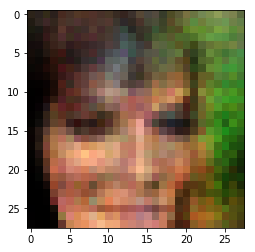

Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.0913
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 3.5048... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 2.5083... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 2.5602... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.0299


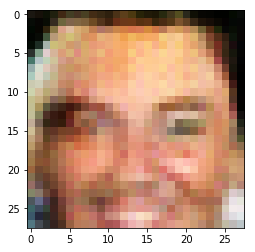

Epoch 1/1... Discriminator Loss: 2.2168... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.8467
Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 2.1692
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 2.0216
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.7851
Epoch 1/1... Discriminator Loss: 2.6470... Generator Loss: 2.5955


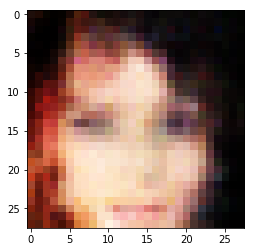

Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 2.6011... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 2.1314... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.8749
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.1732


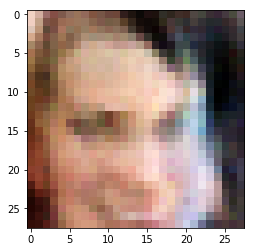

Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 1.8203... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.1619
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.1265
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 1.4380


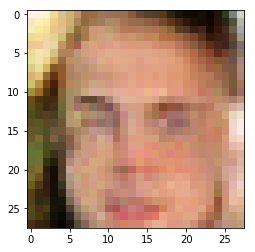

Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 2.4003
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 2.3957
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 1.8991
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.5069
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 4.0647
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.5310
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 3.1971
Epoch 1/1... Discriminator Loss: 2.3976... Generator Loss: 2.5046


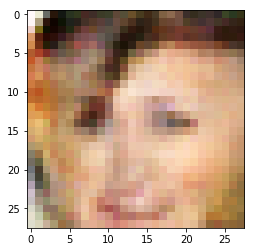

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.5477
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 3.0458
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 3.0509... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.7976... Generator Loss: 0.4736


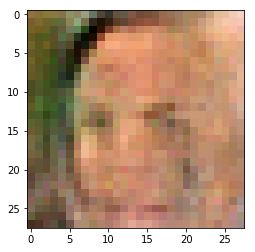

Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 3.1528
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 2.2949... Generator Loss: 2.4026
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 2.8430... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 3.5533


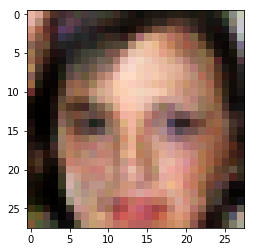

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 3.5583
Epoch 1/1... Discriminator Loss: 2.1327... Generator Loss: 2.6247
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 2.4995
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.1157


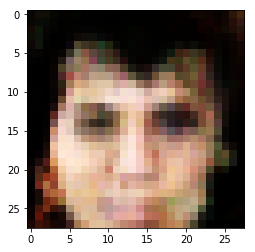

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 4.6050
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.3467
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 3.6353
Epoch 1/1... Discriminator Loss: 3.0136... Generator Loss: 2.1287
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 3.3500


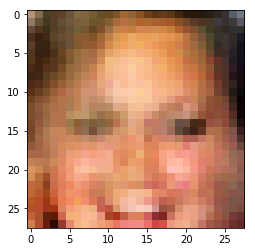

Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 2.5662... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 2.2932... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.7213
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.9963
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.4682
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 2.3914
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.1829
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 2.6403


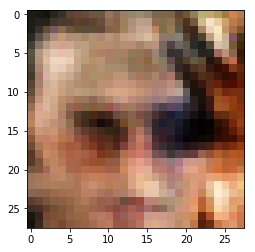

Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 5.0284
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.6960
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.7142
Epoch 1/1... Discriminator Loss: 2.6456... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.3230
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 3.0412... Generator Loss: 0.3411


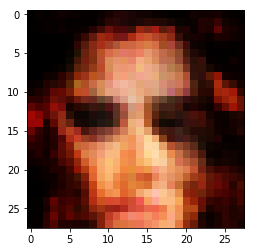

Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 1.6595
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 2.6322
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 3.6565
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 3.2038
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.1665
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 4.7930


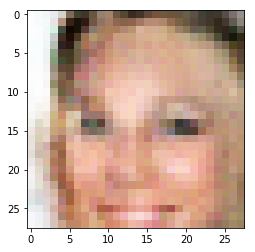

Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 3.3806... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 2.1394... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.3622
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 2.7014
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 2.9752
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 3.7653


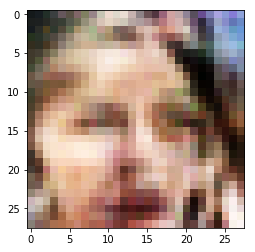

Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.9899
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.2800
Epoch 1/1... Discriminator Loss: 2.2558... Generator Loss: 1.8520
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 2.1460... Generator Loss: 0.4166
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.8350
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.9467
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 2.5721
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.2437


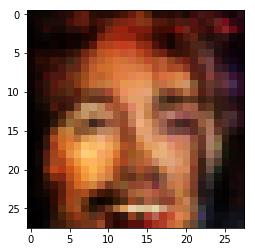

Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 2.8266... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.3646
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.9518... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.0208
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.6130


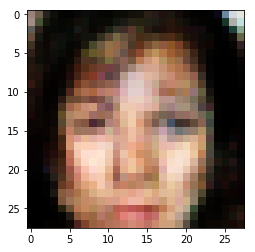

Epoch 1/1... Discriminator Loss: 3.7898... Generator Loss: 0.3707
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.4711
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 4.1363
Epoch 1/1... Discriminator Loss: 2.9363... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.1530


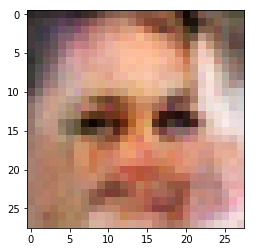

Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 2.3684
Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 2.5894
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 3.7256
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 4.0823
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.9595
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 3.6887
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.2575


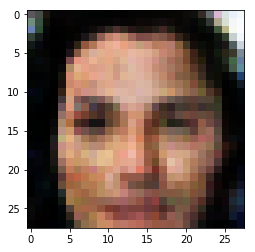

Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.9827


In [13]:
batch_size = 32
z_dim = 2048
learning_rate = 0.0005
beta1 = 0.1



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.